In [1]:
#!/usr/bin/env python

# UV10_analysis.ipynb

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import seaborn as sns


def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


In [14]:
### kinetic energy spectra programs from Julia
def get_ke(u_wind, v_wind):
    """
    Function to compute kinetic energy from horizontal wind. 
    
    Args: 
        uwind(xarray.DataArray): 2D or 3D (when time dimension is included) field with u-component of wind
        vwind(xarray.DataArray): 2D or 3D (when time dimension is included) field with v-component of wind
     
    
    """
    kinetic_energy = 0.5 * (u_wind**2 + v_wind**2)
    
    return kinetic_energy


def get_variances(spectral):
    """
    This function computes sigma squared
    (variances of the spectral coefficients).

    Args:
        spectral(np.array): 2D array with spectral coefficients
    Returns:
        variance(np.array): 2D array with variances

    """
    Ni = spectral.shape[0]
    Nj = spectral.shape[1]
    return (spectral ** 2) / (Ni * Nj)

def get_power_spectrum(variance, dx):
    """
    This function creates a power spectrum for a given field
    of spectral variances.

    Args:
        variance(np.array): 2D field of sigma squared (variances of spectral coefficients)
        dx(float): grid spacing in m or km
    Returns:
        wavelengths(np.array): 1D array with wavelengths (same unit as dx)
        histogram(np.array): binned variances corresponding to wavelengths

    """
    Ni = variance.shape[0]
    Nj = variance.shape[1]
    m, n = np.meshgrid(np.arange(Ni), np.arange(Nj), indexing = 'ij')

    # to ensure that the number of wavenumber bands is not larger than any axis of the domain
    mindim = min(Ni, Nj)
    # array with wavenumber bands
    k = np.arange(1, mindim)
    # normalized k for each element in k space, alpha max should be square root of 2! 
    alpha = np.sqrt(m ** 2 / Ni ** 2 + n ** 2 / Nj ** 2)
    # limits of contributing bands
    lowerbound = k / mindim
    upperbound = (k+1)/ mindim
    
    # binning 
    histogram, bins = np.histogram(alpha.flatten(), bins=upperbound, weights=variance.flatten())
    alpha_mean = np.nanmean([lowerbound, upperbound], axis = 0 )
    wavelengths = 2 * dx / alpha_mean

    return wavelengths, histogram

#### functions to convert between non-dimensional/dimensional wavenumbers and wavelength 

def lambda_to_k(wavelengths):
    """
    This function convert wavelengths lambda in km to wavenumbers k 
    in rad/m. 
    """
    return 2* np.pi/ (wavelengths * 1000)


def k_to_lambda(Ni, Nj, dx):
    """
    This function converts the non-dimensional wavenumbers
    of a 2D k-space to wavelengths that represent the real spatial scale.

    Args:
        Ni(int): number of grid cells in y-direction
        Nj(int): number of grid cells in x-direction
        dx(float): grid spacing in m or km

    Returns:
        lambda_mn(np.array): 2D array with wavelengths for
                            each m,n -pair. The output unit is
                            same unit given for dx.
    """
    m, n = np.meshgrid(np.arange(Ni), np.arange(Nj), indexing = 'ij')
    k = np.sqrt(m ** 2 + n ** 2)

    ########   squared domain case   ##########
    if Ni == Nj:
        lambda_mn = (2 * Ni * (dx)) / k

    else:
        ######## rectangular domain case ##########

        ## normalization of k
        alpha = np.sqrt(m ** 2 / Ni ** 2 + n ** 2 / Nj ** 2)
        # compute wavelength
        lambda_mn = 2 * dx / alpha

    return lambda_mn

In [1]:
def ReadERA5(TIME,      # Time period to read (this program will read hourly data)
            var,        # Variable name. See list below for defined variables
            PL,         # Pressure level of variable
            REGION):    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
    # ----------
    # This function reads hourly ERA5 data for one variable from NCAR's RDA archive in a region of interest.
    # ----------

    DayStart = datetime.datetime(TIME[0].year, TIME[0].month, TIME[0].day,TIME[0].hour)
    DayStop = datetime.datetime(TIME[-1].year, TIME[-1].month, TIME[-1].day,TIME[-1].hour)
    TimeDD=pd.date_range(DayStart, end=DayStop, freq='d')
    Plevels = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000])

    dT = int(divmod((TimeDD[1] - TimeDD[0]).total_seconds(), 60)[0]/60)
    
    # check if variable is defined
    if var == 'V':
        ERAvarfile = 'v.ll025uv'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'V'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'U':
        ERAvarfile = 'u.ll025uv'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'U'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'T':
        ERAvarfile = 't.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'T'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'ZG':
        ERAvarfile = 'z.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'Z'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'Q':
        ERAvarfile = 'q.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/'
        NCvarname = 'Q'
        PL = np.argmin(np.abs(Plevels - PL))
    if var == 'SLP':
        ERAvarfile = 'msl.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'MSL'
        PL = -1
    if var == 'IVTE':
        ERAvarfile = 'viwve.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/'
        NCvarname = 'VIWVE'
        PL = -1
    if var == 'IVTN':
        ERAvarfile = 'viwvn.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/'
        NCvarname = 'VIWVN'
        PL = -1
    if var == 'u10':
        ERAvarfile = '10u.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'VAR_10U'
        PL = -1
    if var == 'v10':
        ERAvarfile = '10v.ll025sc'
        Dir = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/'
        NCvarname = 'VAR_10V'
        PL = -1

    print(ERAvarfile)
    # read in the coordinates
    ncid=Dataset("/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc", mode='r')
    Lat=np.squeeze(ncid.variables['latitude'][:])
    Lon=np.squeeze(ncid.variables['longitude'][:])
    # Zfull=np.squeeze(ncid.variables['Z'][:])
    ncid.close()
    if np.max(Lon) > 180:
        Lon[Lon >= 180] = Lon[Lon >= 180] - 360
    Lon,Lat = np.meshgrid(Lon,Lat)

    # get the region of interest
    if (REGION[1] > 0) & (REGION[3] < 0):
        # region crosses zero meridian
        iRoll = np.sum(Lon[0,:] < 0)
    else:
        iRoll=0
    Lon = np.roll(Lon,iRoll, axis=1)
    iNorth = np.argmin(np.abs(Lat[:,0] - REGION[0]))
    iSouth = np.argmin(np.abs(Lat[:,0] - REGION[2]))+1
    iEeast = np.argmin(np.abs(Lon[0,:] - REGION[1]))+1
    iWest = np.argmin(np.abs(Lon[0,:] - REGION[3]))
    print(iNorth,iSouth,iWest,iEeast)

    Lon = Lon[iNorth:iSouth,iWest:iEeast]
    Lat = Lat[iNorth:iSouth,iWest:iEeast]
    # Z=np.roll(Zfull,iRoll, axis=1)
    # Z = Z[iNorth:iSouth,iWest:iEeast]

    DataAll = np.zeros((len(TIME),Lon.shape[0],Lon.shape[1]), dtype=np.float16); DataAll[:]=np.nan
    tt=0
    
    for mm in range(len(TimeDD)):
        YYYYMM = str(TimeDD[mm].year)+str(TimeDD[mm].month).zfill(2)
        YYYYMMDD = str(TimeDD[mm].year)+str(TimeDD[mm].month).zfill(2)+str(TimeDD[mm].day).zfill(2)
        DirAct = Dir + YYYYMM + '/'
#         if (var == 'SLP') | (var == 'IVTE') | (var == 'IVTN'):
        if PL == -1:
            FILES = glob.glob(DirAct + '*'+ERAvarfile+'*'+YYYYMM+'*.nc')
        else:
            FILES = glob.glob(DirAct + '*'+ERAvarfile+'*'+YYYYMMDD+'*.nc')
        FILES = np.sort(FILES)
        
        TIMEACT = TIME[(TimeDD[mm].year == TIME.year) &  (TimeDD[mm].month == TIME.month) & (TimeDD[mm].day == TIME.day)]
        
        for fi in tqdm(range(len(FILES))): #[7:9]:
#             print(FILES[fi])
            ncid = Dataset(FILES[fi], mode='r')
            time_var = ncid.variables['time']
            dtime = netCDF4.num2date(time_var[:],time_var.units)
            TimeNC = pd.to_datetime([pd.datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in dtime])
            TT = np.isin(TimeNC, TIMEACT)
            if iRoll != 0:
                if PL !=-1:
                    try:
                        DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,PL,iNorth:iSouth,:]), dtype=np.float16)
                    except:
                        stop()
                else:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,iNorth:iSouth,:]), dtype=np.float16)
                ncid.close()
            else:
                if PL !=-1:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,PL,iNorth:iSouth,iWest:iEeast]), dtype=np.float16)
                else:
                    DATAact = np.array(np.squeeze(ncid.variables[NCvarname][TT,iNorth:iSouth,iWest:iEeast]), dtype=np.float16)
                ncid.close()
            # cut out region
            if len(DATAact.shape) == 2:
                DATAact=DATAact[None,:,:]
            DATAact=np.roll(DATAact,iRoll, axis=2)
            if iRoll != 0:
                DATAact = DATAact[:,:,iWest:iEeast]
            else:
                DATAact = DATAact[:,:,:]
            try:
                DataAll[tt:tt+DATAact.shape[0],:,:]=DATAact
            except:
                continue
            tt = tt+DATAact.shape[0]
    return DataAll, Lat, Lon

###  Read CONUS404 data

In [137]:
TimeHH = pd.date_range(datetime.datetime(2010, 1, 1,0), end=datetime.datetime(2021, 12, 31,23), freq='h')
TimeMM = pd.date_range(datetime.datetime(2010, 1, 1,0), end=datetime.datetime(2021, 12, 31,23), freq='m')
years = np.unique(TimeMM.year)
PlotDir = '/glade/campaign/mmm/c3we/prein/CONUS404/plots/UV10_animation/'+ str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10] + '/'
if not os.path.exists(PlotDir):
    os.makedirs(PlotDir)
    
# WRF
WRFdir = '/glade/campaign/ncar/USGS_Water/CONUS404/' 
WRFvar = ['U10','V10']

lon_start = 0
lon_stop = 1366

In [138]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/wrfout_conus404_constants.nc', mode='r')
lon_wrf=np.squeeze(ncid.variables['XLONG'][:,:,lon_start:lon_stop])
lat_wrf=np.squeeze(ncid.variables['XLAT'][:,:,lon_start:lon_stop])
ncid.close()
lon_wrf[lon_wrf > 180] = lon_wrf[lon_wrf > 180]-360

### Load WRF windspeed
###### Data is preprocessed by running - papers/2022_Wind-Changes/programs/data_processing/uv10_data-processing.py

In [139]:
wrf_uv10 = np.zeros((len(TimeHH),lon_wrf.shape[0],lon_wrf.shape[1]), dtype=np.float16); wrf_uv10[:] = np.nan
DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
for yy in tqdm(range(len(years))):
    YYYY = years[yy]
    rgiHours = (TimeHH.year == YYYY) # & (TimeHH.month == MM)
    File_act = DataFolder + 'UV10_'+str(YYYY)+'_CONUS404.npz'
    data = np.load(File_act) # open the netcdf
    wrf_uv10[rgiHours,:,:] = data['wrf_uv10']

KeyboardInterrupt: 

### Read ERA5 data

In [10]:
era_var = ['u10','v10']
REGION = [np.max(lat_wrf),np.max(lon_wrf),np.min(lat_wrf),np.min(lon_wrf)]
era_u10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                    era_var[0],        # Variable name. See list below for defined variables
                    -1,         # Pressure level of variable
                    REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude
era_v10 = ReadERA5(TimeHH,      # Time period to read (this program will read hourly data)
                    era_var[1],        # Variable name. See list below for defined variables
                    -1,         # Pressure level of variable
                    REGION)    # Region to read. Format must be <[N,E,S,W]> in degrees from -180 to +180 longitude

10u.ll025sc
131 290 885 1213
/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_165_10u.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_165_10u.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_165_10u.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_165_10u.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_165_10u.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_165_10u.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_165_10u.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_165_10u.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_165_10u.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_165_10u.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_165_10u.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_165_10u.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_165_10u.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_165_10u.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_165_10u.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_165_10u.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_165_10u.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_165_10u.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_165_10u.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_165_10u.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_165_10u.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_165_10u.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_165_10u.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_165_10u.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


10v.ll025sc
131 290 885 1213
/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198001/e5.oper.an.sfc.128_166_10v.ll025sc.1980010100_1980013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198002/e5.oper.an.sfc.128_166_10v.ll025sc.1980020100_1980022923.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198003/e5.oper.an.sfc.128_166_10v.ll025sc.1980030100_1980033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198004/e5.oper.an.sfc.128_166_10v.ll025sc.1980040100_1980043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198005/e5.oper.an.sfc.128_166_10v.ll025sc.1980050100_1980053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198006/e5.oper.an.sfc.128_166_10v.ll025sc.1980060100_1980063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198007/e5.oper.an.sfc.128_166_10v.ll025sc.1980070100_1980073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198008/e5.oper.an.sfc.128_166_10v.ll025sc.1980080100_1980083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198009/e5.oper.an.sfc.128_166_10v.ll025sc.1980090100_1980093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198010/e5.oper.an.sfc.128_166_10v.ll025sc.1980100100_1980103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198011/e5.oper.an.sfc.128_166_10v.ll025sc.1980110100_1980113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198012/e5.oper.an.sfc.128_166_10v.ll025sc.1980120100_1980123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198101/e5.oper.an.sfc.128_166_10v.ll025sc.1981010100_1981013123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198102/e5.oper.an.sfc.128_166_10v.ll025sc.1981020100_1981022823.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198103/e5.oper.an.sfc.128_166_10v.ll025sc.1981030100_1981033123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198104/e5.oper.an.sfc.128_166_10v.ll025sc.1981040100_1981043023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198105/e5.oper.an.sfc.128_166_10v.ll025sc.1981050100_1981053123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198106/e5.oper.an.sfc.128_166_10v.ll025sc.1981060100_1981063023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198107/e5.oper.an.sfc.128_166_10v.ll025sc.1981070100_1981073123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198108/e5.oper.an.sfc.128_166_10v.ll025sc.1981080100_1981083123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198109/e5.oper.an.sfc.128_166_10v.ll025sc.1981090100_1981093023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198110/e5.oper.an.sfc.128_166_10v.ll025sc.1981100100_1981103123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198111/e5.oper.an.sfc.128_166_10v.ll025sc.1981110100_1981113023.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/198112/e5.oper.an.sfc.128_166_10v.ll025sc.1981120100_1981123123.nc


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [11]:
era_uv10 = (era_u10[0]**2 + era_v10[0]**2)**0.5
lat_era = era_u10[1]
lon_era = era_u10[2]

### Read the U.K. Met Office Hadley Centre Global Sub-Daily Station Observations 

In [15]:
FocRegion = [55, -55, 23, -140] # Focus Model Region - N, E, S, W 

In [16]:
# read station list
STAIONS = pd.read_csv('/glade/campaign/mmm/c3we/prein/observations/hadisd_station/station-list.txt', sep='\s+',header=None)
ID = np.array(STAIONS)[:,0]
LatST = np.array(STAIONS)[:,1]
LonST = np.array(STAIONS)[:,2]
HeigtST = np.array(STAIONS)[:,3]
# Get stations in focus region
SelST = ((LatST >= FocRegion[2]) & (LatST <= FocRegion[0]) & (LonST >= FocRegion[3]) & (LonST <= FocRegion[1]))
ID = ID[SelST]
LatST = LatST[SelST]
LonST = LonST[SelST]
HeigtST = HeigtST[SelST]

rgdTimeST=pd.date_range(datetime.datetime(1931, 1, 1,0), end=datetime.datetime(2020, 1, 1,0), freq='h')
DataST = np.zeros((len(rgdTimeST),len(LonST))); DataST[:] = np.nan

ST_DATA_windspeed = np.zeros((len(rgdTimeST),len(LonST))); ST_DATA_windspeed[:] = np.nan
ST_DATA_winddir = np.copy(ST_DATA_windspeed)
ST_DATA_windgust = np.copy(ST_DATA_windspeed)

for st in tqdm(range(len(LonST))):
    File = '/gpfs/fs1/collections/rda/data/ds463.4/hadisd.3.1.0.2019f_19310101-20200101_'+ID[st]+'.nc'
#     print('    read '+ File)
    # try reading the highest possible precipitation frequency
    if os.path.isfile(File) == True:
        ncid=Dataset(File, mode='r')
        P1h=np.squeeze(ncid.variables['windspeeds'][:]); P1h[P1h < 0] = np.nan
        P3h=np.array(np.squeeze(ncid.variables['winddirs'][:])).astype('float') ; P3h[P3h < 0] = np.nan
        P6h = np.squeeze(ncid.variables['wind_gust'][:]); P6h[P6h < 0] = np.nan
        TimeST = np.squeeze(ncid.variables['time'][:])
        qc_obs = ncid.variables['flagged_obs'][:]
    #     time_var = ncid.variables['time']
    #     dtime = netCDF4.num2date(time_var[:],time_var.units)
        ncid.close()
        
        P1h[qc_obs[:,4].mask == 0] = np.nan
        P3h[qc_obs[:,5].mask == 0] = np.nan

        ST_DATA_windspeed[TimeST.astype('int'),st] = P1h
        ST_DATA_winddir[TimeST.astype('int'),st] = P3h
        ST_DATA_windgust[TimeST.astype('int'),st] = P6h
    
# ST_mask = MakeShapefile(Regions,
#                          LonST,
#                          LatST,
#                          sShapefiles)

# Select Data for period of interest
TTsel = np.isin(rgdTimeST, TimeHH)
ST_DATA_windspeed = ST_DATA_windspeed[TTsel,:]
ST_DATA_winddir = ST_DATA_winddir[TTsel,:]
ST_DATA_windgust = ST_DATA_windgust[TTsel,:]

100%|██████████| 2282/2282 [09:27<00:00,  4.02it/s]


### calculate observational fraction per year and season

In [17]:
# nearest gridcell to station
StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
for st in range(len(LonST)):
    try:
        abslat = np.abs(lat_wrf-LatST[st])
        abslon= np.abs(lon_wrf-LonST[st])
        Loc = np.argmin(np.maximum(abslon,abslat))
        StationsInModel[st,:] = np.unravel_index(Loc, (lat_wrf.shape[0],lat_wrf.shape[1]))
    except:
        continue
StationsInModel = StationsInModel.astype('int')
wrf_stations = wrf_uv10[:,StationsInModel[:,0],StationsInModel[:,1]]

In [18]:
# nearest gridcell to station
StationsInModel = np.zeros((len(LonST),2)); StationsInModel[:] = np.nan
for st in range(len(LonST)):
    try:
        abslat = np.abs(lat_era-LatST[st])
        abslon= np.abs(lon_era-LonST[st])
        Loc = np.argmin(np.maximum(abslon,abslat))
        StationsInModel[st,:] = np.unravel_index(Loc, (lat_era.shape[0],lat_era.shape[1]))
    except:
        continue
StationsInModel = StationsInModel.astype('int')
era_stations = era_uv10[:,StationsInModel[:,0],StationsInModel[:,1]]

In [94]:
obs_frac_season = np.zeros((len(years), 5, ST_DATA_windspeed.shape[1]))
for yy in range(len(years)):
    for se in range(5):
        if se == 0:
            months = [1,2,3,4,5,6,7,8,9,10,11,12]
        elif se == 1:
            months = [1,2,12]
        if se == 2:
            months = [3,4,5]
        if se == 3:
            months = [6,7,8]
        if se == 4:
            months = [9,10,11]
        time_sel = (TimeHH.year == years[yy]) & np.isin(TimeHH.month, months)
        for st in range(ST_DATA_windspeed.shape[1]):
            obs_frac_season[yy,se,st] = np.sum(~np.isnan(ST_DATA_windspeed[time_sel,st]))/sum(time_sel)

### Bin the wind speed data to the observational accuracy

In [36]:
unique_wind = np.unique(ST_DATA_windspeed[:,:])
unique_wind = unique_wind[~np.isnan(unique_wind)]

In [113]:
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
wrf_wind_discrete = np.copy(wrf_stations)
era_wind_discrete = np.copy(era_stations)
for st in tqdm(range(wrf_stations.shape[1])):
    for hh in range(wrf_stations.shape[0]):
        wrf_wind_discrete[hh, st] = find_nearest(unique_wind, wrf_stations[hh, st])
        era_wind_discrete[hh, st] = find_nearest(unique_wind, era_stations[hh, st])

100%|██████████| 2282/2282 [05:48<00:00,  6.55it/s]


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

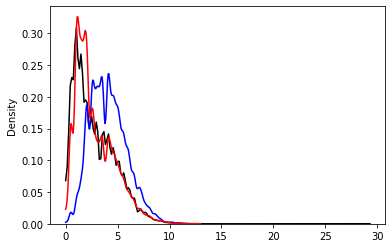

In [109]:
st = 2002
# sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
FIN = ~np.isnan(ST_DATA_windspeed[:,st])
sns.kdeplot(ST_DATA_windspeed[FIN,st].flatten(), cut=0, c='k', bw=0.1)
sns.kdeplot(era_wind_discrete[FIN,st].flatten(), cut=0, c='b', bw=0.1)
sns.kdeplot(wrf_wind_discrete[FIN,st].flatten(), cut=0, c='r', bw=0.1)

In [118]:
st = 2002
# sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
FIN = ~np.isnan(ST_DATA_windspeed[:,st])
print(np.percentile(ST_DATA_windspeed[FIN,st].flatten(), (1,5,25,50,75,95,99)))
print(np.percentile(era_wind_discrete[FIN,st].flatten(), (1,5,25,50,75,95,99)))
print(np.percentile(wrf_wind_discrete[FIN,st].flatten(), (1,5,25,50,75,95,99)))

[0.  0.5 1.  2.5 4.1 6.6 8.2]
[1.  1.5 2.8 4.  5.2 7.2 8.7]
[0.5        0.5        1.5        2.09960938 4.         6.3984375
 8.203125  ]


Text(0.5, 1.0, 'wrf')

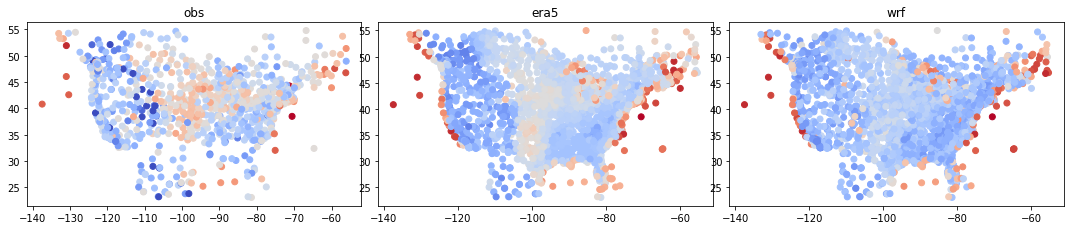

In [129]:
fig = plt.figure(figsize=(16,3))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.35)

ax = plt.subplot(gs1[0,0])
plt.scatter(LonST,LatST, c=np.nanmedian(ST_DATA_windspeed, axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('obs')

ax = plt.subplot(gs1[0,1])
plt.scatter(LonST,LatST, c=np.nanmedian(era_wind_discrete, axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('era5')

ax = plt.subplot(gs1[0,2])
plt.scatter(LonST,LatST, c=np.nanmedian(wrf_wind_discrete, axis=0), cmap='coolwarm', vmin=0, vmax=8)
plt.title('wrf')

Text(0.5, 1.0, 'wrf')

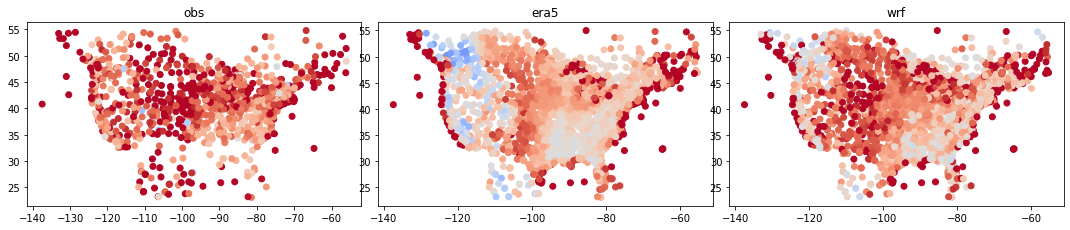

In [136]:
fig = plt.figure(figsize=(16,3))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.35)

ax = plt.subplot(gs1[0,0])
plt.scatter(LonST,LatST, c=np.nanpercentile(ST_DATA_windspeed, 99.9, axis=0), cmap='coolwarm', vmin=0, vmax=15)
plt.title('obs')

ax = plt.subplot(gs1[0,1])
plt.scatter(LonST,LatST, c=np.nanpercentile(era_wind_discrete, 99.9, axis=0), cmap='coolwarm', vmin=0, vmax=15)
plt.title('era5')

ax = plt.subplot(gs1[0,2])
plt.scatter(LonST,LatST, c=np.nanpercentile(wrf_wind_discrete, 99.9, axis=0), cmap='coolwarm', vmin=0, vmax=15)
plt.title('wrf')

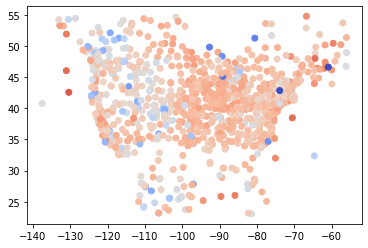

In [115]:
correlations = np.zeros((ST_DATA_windspeed.shape[1],2)); correlations[:] = np.nan
for st in range(ST_DATA_windspeed.shape[1]):
    FIN = ~np.isnan(ST_DATA_windspeed[:,st])
    try:
        correlations[st,:] = scipy.stats.pearsonr(ST_DATA_windspeed[FIN,st],wrf_stations[FIN,st])
    except:
        continue
        
plt.scatter(LonST,LatST, c=correlations[:,0], cmap='coolwarm', vmin=0, vmax=1)

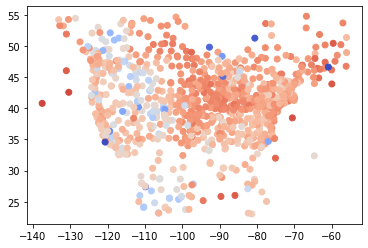

In [116]:
correlations_era = np.zeros((ST_DATA_windspeed.shape[1],2)); correlations_era[:] = np.nan
for st in range(ST_DATA_windspeed.shape[1]):
    FIN = ~np.isnan(ST_DATA_windspeed[:,st])
    try:
        correlations_era[st,:] = scipy.stats.pearsonr(ST_DATA_windspeed[FIN,st],era_stations[FIN,st])
    except:
        continue
plt.scatter(LonST,LatST, c=correlations_era[:,0], cmap='coolwarm', vmin=0, vmax=1)

### Plot the data

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [12]:
# # ========= plot 4 km
# #plot blue ocean and lakes
# clevs=0

# ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
# HGT_M = getvar(ncfile, "HGT_M")
# cart_proj = get_cartopy(HGT_M)
# ncid.close()

# for tt in tqdm(range(len(TimeHH))):

#     fig = plt.figure(figsize=(25,9.5))
#     plt.rcParams.update({'font.size': 18})
#     gs1 = gridspec.GridSpec(1,2)
#     gs1.update(left=0.05, right=0.99,
#                bottom=0.21, top=0.93,
#                wspace=0.05, hspace=0.15)


#     datasets = ['ERA5','CONUS404']
#     for da in range(len(datasets)):
#         ax = plt.subplot(gs1[0,da], projection=cart_proj)
#         pos1 = ax.get_position()
#         if datasets[da] == 'ERA5':
#             data = np.copy(era_uv10[tt,:])
#             lat = lat_era
#             lon = lon_era
#         if datasets[da] == 'CONUS404':
#             data = np.copy(wrf_uv10[tt,:])
#             lat = lat_wrf
#             lon = lon_wrf


#         cs = plt.pcolormesh(lon, lat, data,
#                               vmin=0,
#                               vmax = 10, 
#                               cmap = 'Spectral_r', transform=ccrs.PlateCarree())

#         ax.coastlines()
#         ax.add_feature(cf.BORDERS)
#         ax.add_feature(cf.STATES, lw=0.5)
#         ax.set_extent((-123, -73, 22, 55), ccrs.PlateCarree())

#         gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#         gl.right_labels = False

#         plt.title(datasets[da]+' '+str(TimeHH[tt])[:13]+': 10 m wind speed')


#     # Add a color bar
#     cb = plt.colorbar(cs, ax=ax, shrink=.98)
#     cb.set_label('10 m wind speed [m/s]', fontsize=18)


#     sPlotFile=PlotDir
#     sPlotName= str(tt).zfill(3)+'_CONUS404-vs-ERA5_uv10_'+str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10]+'.jpg'
#     if os.path.isdir(sPlotFile) != 1:
#         subprocess.call(["mkdir","-p",sPlotFile])
# #     print( '        Plot map to: '+sPlotFile+sPlotName)
#     fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)


### Plot PDF of wind speed in central US

In [13]:
foc_region = [40, -95, 35, -100]

era_region = (lat_era >= foc_region[2]) & (lat_era <= foc_region[0]) & \
             (lon_era >= foc_region[3]) & (lon_era <= foc_region[1])
era_region = era_uv10[:,era_region]
era_pdf = era_region.flatten()


wrf_region = (lat_wrf >= foc_region[2]) & (lat_wrf <= foc_region[0]) & \
             (lon_wrf >= foc_region[3]) & (lon_wrf <= foc_region[1])
wrf_region = wrf_uv10[:,wrf_region]
wrf_pdf = wrf_region.flatten()

In [14]:
yy_w,xx_w = plt.psd(wrf_region[:,1000], 512, 1/24, c='r')
plt.close()
yy_e,xx_e = plt.psd(era_region[:,100], 512, 1/24, c='k')
plt.close()

### Spetral kinetic energey spectra (code from Julia)

In [15]:
import numpy as np 
import xarray as xr
from pathlib import Path
from scipy import fft # package needed for DCT transformation


# plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

In [17]:
foc_region = [49, -85, 30, -105]
wrf_region = (lat_wrf >= foc_region[2]) & (lat_wrf <= foc_region[0]) & \
             (lon_wrf >= foc_region[3]) & (lon_wrf <= foc_region[1])
wrf_iregion = [np.where(np.max(wrf_region, axis=1) == True)[0][0],
                np.where(np.max(wrf_region, axis=1) == True)[0][-1],
                np.where(np.max(wrf_region, axis=0) == True)[0][0],
                np.where(np.max(wrf_region, axis=0) == True)[0][-1]]

era_region = (lat_era >= foc_region[2]) & (lat_era <= foc_region[0]) & \
             (lon_era >= foc_region[3]) & (lon_era <= foc_region[1])
era_iregion = [np.where(np.max(era_region, axis=1) == True)[0][0],
                np.where(np.max(era_region, axis=1) == True)[0][-1],
                np.where(np.max(era_region, axis=0) == True)[0][0],
                np.where(np.max(era_region, axis=0) == True)[0][-1]]

In [18]:
### Work on WRF
wrf_region_u = wrf_data[:,wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3],0]
wrf_region_v = wrf_data[:,wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3],1]

# define grid spacing in km (not needed to use metpy library if you know dx)
from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(lon_wrf[wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3]], 
                             lat_wrf[wrf_iregion[0]:wrf_iregion[1],wrf_iregion[2]:wrf_iregion[3]])
dx  = np.mean(np.array(dx[1:] + dy[:,:-1]) / 2 ) / 1000

# loop through timesteps 
kinetic_energy = get_ke(wrf_region_u, wrf_region_v)
histograms = np.zeros((kinetic_energy.shape[0], kinetic_energy.shape[2] - 2 ))

for tt in range(kinetic_energy.shape[0]): # enumerate(kinetic_energy.time):    
    # first: transform to spectral space and get variances
    variances = get_variances(fft.dctn(np.array(kinetic_energy[tt,:]), norm = 'ortho'))

    # then: get power spectrum of variances (spectral coefficients)
    wavelengths, histograms[tt] = get_power_spectrum(variances, dx)

KeyboardInterrupt: 

In [ ]:
### Work on ERA
era_region_u = era_u10[0][:,era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]]
era_region_v = era_v10[0][:,era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]]

# define grid spacing in km (not needed to use metpy library if you know dx)
from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(lon_era[era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]][::-1,:], 
                             lat_era[era_iregion[0]:era_iregion[1],era_iregion[2]:era_iregion[3]][::-1,:])
dx  = np.mean(np.array(dx[1:] + dy[:,:-1]) / 2 ) / 1000

# loop through timesteps 
kinetic_energy = get_ke(era_region_u, era_region_v)
histograms_era = np.zeros((kinetic_energy.shape[0], kinetic_energy.shape[1] - 2 ))

for tt in range(kinetic_energy.shape[0]): # enumerate(kinetic_energy.time):    
    # first: transform to spectral space and get variances
    variances = get_variances(fft.dctn(np.array(kinetic_energy[tt,:]), norm = 'ortho'))

    # then: get power spectrum of variances (spectral coefficients)
    wavelengths_era, histograms_era[tt] = get_power_spectrum(variances, dx)

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1) 

# sizes
lw = 2.2
fs = 18 

# actual plot
ax.plot(wavelengths[1:], np.nanmean(histograms, axis =0), label = 'WRF 4km', lw = 2.8, color='k')
ax.plot(wavelengths_era[1:], np.nanmean(histograms_era, axis =0), label = 'ERA5', lw = 2.8, color='r')
ax.legend(fontsize = 20)

# log axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()

# grid lines 
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)

# labels
ax.set_ylabel('Kinetic energy spectrum @10m [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# show wavenumber k on upper x-axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)


################################ add theoretical slope for meso-scale ###########################

intercept= 1 # y coordinate for start (adjust here to specify location on y-axis)
ki =  0.00004  # corresponding k coordinate on x axis to start line (adjust here to specify location on x-axis)
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-3.5), 101) # k values for x axis (adjust to define end of line in x-direction)
ax2.plot(k, k**(-5/3) * c, 'darkorange', linestyle='--', linewidth = lw) # linear equation multiplied by c to move the intercept on log scale)
ax2.text(ki+ 0.0001,intercept-0.7, 'k$^{-5/3}$', color = 'darkorange', fontsize = 24) 

# same for large-scale
intercept= 5
ki =  0.000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 6*10**(-5), 101)
ax2.text(ki+ 0.000015,1.4, 'k$^{-3}$', color = 'plum', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'plum', linestyle='--', linewidth= lw)


plt.show()

In [ ]:
fig = plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 16})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.05, right=0.99,
           bottom=0.21, top=0.93,
           wspace=0.35, hspace=0.35)

ax = plt.subplot(gs1[0,0])
sns.kdeplot(era_pdf, cut=0, c='k', bw=0.1)
sns.kdeplot(wrf_pdf, cut=0, c='r', bw=0.1)

# ax.set_ylim((0,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')


# log y scale
ax = plt.subplot(gs1[0,1])

# Make default density plot
sns.kdeplot(era_pdf, cut=0, c='k', bw=0.1)
sns.kdeplot(wrf_pdf, cut=0, c='r', bw=0.1)

ax.set_yscale('log')
ax.set_ylim((0.0000001,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')


# =====================================================
# =====================================================
# =====================================================
# Energy density function temporal
ax = plt.subplot(gs1[1,0])
plt.plot(xx_w, 10*np.log10(yy_w), c='r', label = 'WRF 4km')
plt.plot(xx_e, 10*np.log10(yy_e), c='k', label = 'ERA5')
# plt.plot(xx,10*np.log10(era_spectra), c='k')

plt.axvline(x=(1/24)/24, c='k', lw=0.5)
plt.text((1/24)/24*1.04,8,'1 day',rotation=90, fontsize=10)
plt.axvline(x=(1/24)/12, c='k', lw=0.5)
plt.text((1/24)/12*1.04,8,'12 hours',rotation=90, fontsize=10)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((7,60))
plt.legend()
plt.title('wind speed energy spectra ')
ax.set_xlabel('Frequency [1/hours]')
ax.set_ylabel('power spectral density [dB Hz$^{-1}$]', fontsize = fs)

# yy_pl = np.array([0.0005*jj**(-5/3) for jj in xx_w])
# plt.plot(xx_w,yy_pl, c='k', ls='--')

# yy_pl = np.array([0.0000000001*jj**(-3) for jj in xx_w])
# plt.plot(xx_w,yy_pl, c='k', ls='--')



# =====================================================
# =====================================================
# =====================================================
# Kinetic Energy spectra
ax = plt.subplot(gs1[1,1])
# sizes
lw = 2.2
fs = 18 

# actual plot
ax.plot(wavelengths[1:], np.nanmean(histograms, axis =0), label = 'WRF 4km', lw = 2.8, color='r')
ax.plot(wavelengths_era[1:], np.nanmean(histograms_era, axis =0), label = 'ERA5', lw = 2.8, color='k')
# ax.legend(fontsize = 20)

# log axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_xaxis()

# grid lines 
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)

# labels
ax.set_ylabel('Kinetic energy spectrum\n@10m [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# show wavenumber k on upper x-axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)



################################ add theoretical slope for meso-scale ###########################

intercept= 1 # y coordinate for start (adjust here to specify location on y-axis)
ki =  0.00004  # corresponding k coordinate on x axis to start line (adjust here to specify location on x-axis)
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-3.5), 101) # k values for x axis (adjust to define end of line in x-direction)
ax2.plot(k, k**(-5/3) * c, 'darkorange', linestyle='--', linewidth = lw) # linear equation multiplied by c to move the intercept on log scale)
ax2.text(ki+ 0.0001,intercept-0.7, 'k$^{-5/3}$', color = 'darkorange', fontsize = 24) 

# same for large-scale
intercept= 5
ki =  0.000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 6*10**(-5), 101)
ax2.text(ki+ 0.000015,1.4, 'k$^{-3}$', color = 'plum', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'plum', linestyle='--', linewidth= lw)


sPlotFile=PlotDir
sPlotName= 'PDF_CONUS404-vs-ERA5_uv10_'+str(TimeHH[0])[:10] + '-' +str(TimeHH[-1])[:10]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

In [ ]:
print( '        Plot map to: '+sPlotFile+sPlotName)

In [ ]:
plt.plot(TimeHH[400:750], ST_DATA_windspeed[400:750,1004], c='k')
plt.plot(TimeHH[400:750], wrf_stations[400:750,1004], c='r')
plt.plot(TimeHH[400:750], era_stations[400:750,1004], c='b')

In [ ]:
np.nanmax(ST_DATA_windspeed[:,1004])
np.nanmax(era_stations[:,1004])
np.nanmax(wrf_stations[:,1004])

In [ ]:
fig = plt.figure(figsize=(14,12))
plt.rcParams.update({'font.size': 16})
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.05, right=0.99,
           bottom=0.21, top=0.93,
           wspace=0.35, hspace=0.35)

ax = plt.subplot(gs1[0,0])
sns.kdeplot(ST_DATA_windspeed.flatten(), cut=0, c='k', bw=0.1)
sns.kdeplot(era_stations.flatten(), cut=0, c='b', bw=0.1)
sns.kdeplot(wrf_stations.flatten(), cut=0, c='r', bw=0.1)

# ax.set_ylim((0,1))
ax.set_xlim((0,28))
ax.set_xlabel('hourly wind speed at 10 m [m/s]')

In [ ]:
st = 311
sns.kdeplot(ST_DATA_windspeed[ST_DATA_windspeed[:,st]>0,st].flatten(), cut=0, c='k', bw=0.1)
sns.kdeplot(era_stations[:,st].flatten(), cut=0, c='b', bw=0.1)
sns.kdeplot(wrf_stations[:,st].flatten(), cut=0, c='r', bw=0.1)